In [1]:
import os
import pandas as pd
import geopandas as gpd
import sklearn
import contextily as ctx
import datetime
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 200)

%load_ext autoreload
%autoreload 2

from tqdm import tqdm
tqdm.pandas()

from util.isochrones import Isochrones
from util.gtfsdownloader import GtfsDownloader
from util.graphhopper import Graphhopper

import logging
logging.getLogger().setLevel(logging.INFO)
logging.getLogger().addHandler(logging.StreamHandler())

DROOT = os.path.join('./1-data/')
drootf = lambda path: os.path.join(DROOT, path)

(4053, 41)


,postcode4,aantal_inwoners,aantal_mannen,aantal_vrouwen,aantal_inwoners_0_tot_15_jaar,aantal_inwoners_15_tot_25_jaar,aantal_inwoners_25_tot_45_jaar,aantal_inwoners_45_tot_65_jaar,aantal_inwoners_65_jaar_en_ouder,percentage_geb_nederland_herkomst_nederland,percentage_geb_nederland_herkomst_overig_europa,percentage_geb_nederland_herkomst_buiten_europa,percentage_geb_buiten_nederland_herkomst_europa,percentage_geb_buiten_nederland_herkmst_buiten_europa,aantal_part_huishoudens,aantal_eenpersoonshuishoudens,aantal_meerpersoonshuishoudens_zonder_kind,aantal_eenouderhuishoudens,aantal_tweeouderhuishoudens,gemiddelde_huishoudensgrootte,aantal_woningen,aantal_woningen_bouwjaar_voor_1945,aantal_woningen_bouwjaar_45_tot_65,aantal_woningen_bouwjaar_65_tot_75,aantal_woningen_bouwjaar_75_tot_85,aantal_woningen_bouwjaar_85_tot_95,aantal_woningen_bouwjaar_95_tot_05,aantal_woningen_bouwjaar_05_tot_15,aantal_woningen_bouwjaar_15_en_later,aantal_meergezins_woningen,percentage_koopwoningen,percentage_huurwoningen,aantal_huurwoningen_in_bezit_woningcorporaties,aantal_niet_bewoonde_woningen,gemiddelde_woz_waarde_woning,aantal_personen_met_uitkering_onder_aowlft,omgevingsadressendichtheid,stedelijkheid,geometry,kmarea,utm_centroid
0,1184.0,625,320,305,100,90,110,215,110,70,10,10,10,10,255,70,70,20,95,2.4,245,165,10,-99997,10,20,10,25,-99997,20,80,20,15,10,902,15,585,4,"MULTIPOLYGON (((629092.107 5795860.327, 629139...",0.121549,POINT (629074.569 5795763.369)


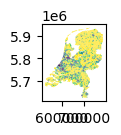

In [2]:
# Load postcodes
postcodes = gpd.read_file(drootf('2023-CBS_pc4_2022_v1/cbs_pc4_2022_v1.gpkg'))
CRS_DEFAULT = postcodes.estimate_utm_crs()
postcodes = postcodes.to_crs(CRS_DEFAULT)

# Set details
postcodes.postcode4 = postcodes.postcode4.astype(float)
postcodes['kmarea'] = postcodes.area / 10e6 # to Km2
postcodes['utm_centroid'] = postcodes.centroid
postcodes = postcodes[postcodes.stedelijkheid > 0] # Some regions with harbours
pc_reduced = postcodes[['postcode4', 'stedelijkheid', 'geometry', 'utm_centroid']]

# Display
ax = postcodes.plot(figsize=(1,1), column='stedelijkheid')
print(postcodes.shape)
postcodes.head(1)

In [3]:
# Set example mask coordinates and use columns lists for BAG data.
coords = [(4.723223399790179, 52.82387348804171), 
                (4.943932049601555, 52.819746789026915), 
                (4.938184404627946, 52.69718243028993), 
                (4.711532182168482, 52.716038791893496)]
mask = gpd.GeoSeries(Polygon(coords), crs="EPSG:4326")
uses_list = ['bijeenkomst', 'cel', 'gezondheidszorg', 'industrie', 'kantoor', 'logies', 'onderwijs', 'overige_gebruiks', 'sport', 'winkel', 'woon']

# With enough RAM, this should take about 5 minutes. 
bag_path = drootf('explore-bag/snapshot_20230701.gpkg')
bag_gdf = gpd.read_file(bag_path, layer='vbo', engine="pyogrio")
bag_gdf = bag_gdf.to_crs(CRS_DEFAULT)
bag_gdf.head(2)

,identificatie,oppervlakte,nummeraanduiding_id,pand_id,pand_id_geom,StatusCode,BEGINDATUM,EINDDATUM,VOORKOMENIDENTIFICATIE,TIJDSTIPREGISTRATIE,EINDREGISTRATIE,DOCUMENTDATUM,DOCUMENTNUMMER,bijeenkomst,cel,gezondheidszorg,industrie,kantoor,logies,onderwijs,overige_gebruiks,sport,winkel,woon,geometry
0,0000010000057469,72,0000200000057534,1883100000010452,1883100000010452,5,20180404,0,2,2018-04-04T11:59:28.000,,20180404,correctie,False,False,False,False,False,False,False,False,False,False,True,POINT (700869.965 5653720.681)
1,0003010000125985,69,0003200000134057,0003100000122770,0003100000122770,4,20100720,0,1,2010-10-20T08:43:37.000,,20100720,FB 2010/PANDEN001,False,False,False,False,False,False,False,False,False,False,True,POINT (756691.256 5914930.271)


In [4]:
iso_gdf = pd.read_pickle(drootf('pc_gdf_reach.pcl'))
iso_gdf = gpd.GeoDataFrame(iso_gdf).set_geometry('isochrone')
iso_gdf['isochrone'] = iso_gdf.to_crs(CRS_DEFAULT).buffer(50)
iso_gdf.head(2)

,uid,pid,startpt,trmode,tt_mnts,dep_dt,source,city_id,isochrone,cache_avail,index_right,postcode4,aantal_inwoners,aantal_mannen,aantal_vrouwen,aantal_inwoners_0_tot_15_jaar,aantal_inwoners_15_tot_25_jaar,aantal_inwoners_25_tot_45_jaar,aantal_inwoners_45_tot_65_jaar,aantal_inwoners_65_jaar_en_ouder,percentage_geb_nederland_herkomst_nederland,percentage_geb_nederland_herkomst_overig_europa,percentage_geb_nederland_herkomst_buiten_europa,percentage_geb_buiten_nederland_herkomst_europa,percentage_geb_buiten_nederland_herkmst_buiten_europa,aantal_part_huishoudens,aantal_eenpersoonshuishoudens,aantal_meerpersoonshuishoudens_zonder_kind,aantal_eenouderhuishoudens,aantal_tweeouderhuishoudens,gemiddelde_huishoudensgrootte,aantal_woningen,aantal_woningen_bouwjaar_voor_1945,aantal_woningen_bouwjaar_45_tot_65,aantal_woningen_bouwjaar_65_tot_75,aantal_woningen_bouwjaar_75_tot_85,aantal_woningen_bouwjaar_85_tot_95,aantal_woningen_bouwjaar_95_tot_05,aantal_woningen_bouwjaar_05_tot_15,aantal_woningen_bouwjaar_15_en_later,aantal_meergezins_woningen,percentage_koopwoningen,percentage_huurwoningen,aantal_huurwoningen_in_bezit_woningcorporaties,aantal_niet_bewoonde_woningen,gemiddelde_woz_waarde_woning,aantal_personen_met_uitkering_onder_aowlft,omgevingsadressendichtheid,stedelijkheid,geometry,kmarea,centroid_utm
0,NL-0-transit_off-30m-g,0,POINT (4.89239 52.29702),transit_off,30,2023-10-03 08:30:00+02:00,g,NL,"POLYGON ((4.77416 52.78650, 4.77416 52.78650, ...",True,0,1184,625,320,305,100,90,110,215,110,70,10,10,10,10,255,70,70,20,95,2.4,245,165,10,-99997,10,20,10,25,-99997,20,80,20,15,10,902,15,585,4,"MULTIPOLYGON (((121294.892 478995.293, 121341....",0.121549,POINT (4.89281 52.29704)
1,NL-0-transit_bike_off-30m-g,0,POINT (4.89239 52.29702),transit_bike_off,30,2023-10-03 08:30:00+02:00,g,NL,"MULTIPOLYGON (((4.90843 52.79254, 4.90843 52.7...",True,0,1184,625,320,305,100,90,110,215,110,70,10,10,10,10,255,70,70,20,95,2.4,245,165,10,-99997,10,20,10,25,-99997,20,80,20,15,10,902,15,585,4,"MULTIPOLYGON (((121294.892 478995.293, 121341....",0.121549,POINT (4.89281 52.29704)


In [12]:
iso_gdf['isochrone'] = iso_gdf.to_crs(CRS_DEFAULT).buffer(50)

In [6]:
coords = [(4.723223399790179, 52.82387348804171), 
                (4.943932049601555, 52.819746789026915), 
                (4.938184404627946, 52.69718243028993), 
                (4.711532182168482, 52.716038791893496)]
mask = gpd.GeoSeries(Polygon(coords), crs="EPSG:4326").to_crs(CRS_DEFAULT)

In [11]:
facilities = iso_gdf.iloc[:3].isochrone.progress_apply(lambda x: bag_gdf[bag_gdf.within(x)][uses_list].sum())
facilities

100%|██████████| 3/3 [00:10<00:00,  3.10s/it]/Users/ivo/mambaforge/envs/thesis-env/lib/python3.11/site-packages/geopandas/geoseries.py:660: FutureWarning: Returning a DataFrame from Series.apply when the supplied function returns a Series is deprecated and will be removed in a future version.
  result = super().apply(func, args=args, **kwargs)
100%|██████████| 3/3 [00:10<00:00,  3.66s/it]


,bijeenkomst,cel,gezondheidszorg,industrie,kantoor,logies,onderwijs,overige_gebruiks,sport,winkel,woon
0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0


In [10]:
pd.concat([facilities, iso_gdf.iloc[:3]], axis=1)

,0,uid,pid,startpt,trmode,tt_mnts,dep_dt,source,city_id,isochrone,cache_avail,index_right,postcode4,aantal_inwoners,aantal_mannen,aantal_vrouwen,aantal_inwoners_0_tot_15_jaar,aantal_inwoners_15_tot_25_jaar,aantal_inwoners_25_tot_45_jaar,aantal_inwoners_45_tot_65_jaar,aantal_inwoners_65_jaar_en_ouder,percentage_geb_nederland_herkomst_nederland,percentage_geb_nederland_herkomst_overig_europa,percentage_geb_nederland_herkomst_buiten_europa,percentage_geb_buiten_nederland_herkomst_europa,percentage_geb_buiten_nederland_herkmst_buiten_europa,aantal_part_huishoudens,aantal_eenpersoonshuishoudens,aantal_meerpersoonshuishoudens_zonder_kind,aantal_eenouderhuishoudens,aantal_tweeouderhuishoudens,gemiddelde_huishoudensgrootte,aantal_woningen,aantal_woningen_bouwjaar_voor_1945,aantal_woningen_bouwjaar_45_tot_65,aantal_woningen_bouwjaar_65_tot_75,aantal_woningen_bouwjaar_75_tot_85,aantal_woningen_bouwjaar_85_tot_95,aantal_woningen_bouwjaar_95_tot_05,aantal_woningen_bouwjaar_05_tot_15,aantal_woningen_bouwjaar_15_en_later,aantal_meergezins_woningen,percentage_koopwoningen,percentage_huurwoningen,aantal_huurwoningen_in_bezit_woningcorporaties,aantal_niet_bewoonde_woningen,gemiddelde_woz_waarde_woning,aantal_personen_met_uitkering_onder_aowlft,omgevingsadressendichtheid,stedelijkheid,geometry,kmarea,centroid_utm
0,"[131, 0, 188, 463, 294, 12, 34, 841, 26, 309, ...",NL-0-transit_off-30m-g,0,POINT (4.89239 52.29702),transit_off,30,2023-10-03 08:30:00+02:00,g,NL,"POLYGON ((4.77416 52.78650, 4.77416 52.78650, ...",True,0,1184,625,320,305,100,90,110,215,110,70,10,10,10,10,255,70,70,20,95,2.4,245,165,10,-99997,10,20,10,25,-99997,20,80,20,15,10,902,15,585,4,"MULTIPOLYGON (((121294.892 478995.293, 121341....",0.121549,POINT (4.89281 52.29704)
1,"[259, 0, 259, 1600, 370, 1450, 58, 1244, 43, 4...",NL-0-transit_bike_off-30m-g,0,POINT (4.89239 52.29702),transit_bike_off,30,2023-10-03 08:30:00+02:00,g,NL,"MULTIPOLYGON (((4.90843 52.79254, 4.90843 52.7...",True,0,1184,625,320,305,100,90,110,215,110,70,10,10,10,10,255,70,70,20,95,2.4,245,165,10,-99997,10,20,10,25,-99997,20,80,20,15,10,902,15,585,4,"MULTIPOLYGON (((121294.892 478995.293, 121341....",0.121549,POINT (4.89281 52.29704)
2,"[2719, 5, 1877, 14078, 4108, 9573, 536, 14402,...",NL-0-driving_off-25m-g,0,POINT (4.89239 52.29702),driving_off,25,2023-10-03 08:30:00+02:00,g,NL,"POLYGON ((4.63366 52.62118, 4.63380 52.62117, ...",True,0,1184,625,320,305,100,90,110,215,110,70,10,10,10,10,255,70,70,20,95,2.4,245,165,10,-99997,10,20,10,25,-99997,20,80,20,15,10,902,15,585,4,"MULTIPOLYGON (((121294.892 478995.293, 121341....",0.121549,POINT (4.89281 52.29704)
3,"[260, 0, 259, 1746, 388, 1330, 58, 1263, 46, 4...",NL-0-cycling-30m-g,0,POINT (4.89239 52.29702),cycling,30,2023-10-03 08:30:00+02:00,g,NL,"POLYGON ((4.69872 52.78816, 4.69866 52.78819, ...",True,0,1184,625,320,305,100,90,110,215,110,70,10,10,10,10,255,70,70,20,95,2.4,245,165,10,-99997,10,20,10,25,-99997,20,80,20,15,10,902,15,585,4,"MULTIPOLYGON (((121294.892 478995.293, 121341....",0.121549,POINT (4.89281 52.29704)
4,"[133, 0, 188, 484, 295, 14, 34, 841, 26, 309, ...",NL-0-walking-30m-g,0,POINT (4.89239 52.29702),walking,30,2023-10-03 08:30:00+02:00,g,NL,"POLYGON ((4.77512 52.78684, 4.77511 52.78684, ...",True,0,1184,625,320,305,100,90,110,215,110,70,10,10,10,10,255,70,70,20,95,2.4,245,165,10,-99997,10,20,10,25,-99997,20,80,20,15,10,902,15,585,4,"MULTIPOLYGON (((121294.892 478995.293, 121341....",0.121549,POINT (4.89281 52.29704)
